In [1]:
# IMPORT LIBRARIES
# Secrets library for random number generation
import secrets
# Dilithium library for signing
from dilithium_py.dilithium import Dilithium2
# Kyber library for key encapsulation
from kyber_py.ml_kem import ML_KEM_512
# Crypto library for AES encryption
from Crypto import Cipher, Util
from Crypto.Cipher import AES
from Crypto.Util import Padding
from Crypto.Util.Padding import pad, unpad
# IO library for memory management
from io import BytesIO
# Qiskit libraries
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, transpile, qpy, quantum_info
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
# Qiskit visualization libraries
from qiskit.visualization import plot_histogram

In [2]:
# SIGNCRYPTION
# Generate pk and sk using Dilithium2, these keys will be used to verify and sign, respectively
pk, sk = Dilithium2.keygen()

In [3]:
# Prepare a quantum message
qc_message = QuantumCircuit(1) # 1 qubit
# Apply random rotation for added randomness
qc_message.ry(secrets.randbelow(360), 0)
simulator = AerSimulator()
# Transpile on Aer simulator to optimize the circuit
transpiled_quantum_message = transpile(qc_message, simulator)
result = simulator.run(transpiled_quantum_message).result()
# Extract the quantum state produced by the circuit
quantum_message = Statevector.from_instruction(qc_message)
# Quantum message is ready
print (f"Quantum message |q>: {quantum_message}")
# The  dims is 2 because of superposition

Quantum message |q>: Statevector([ 0.99683099+0.j, -0.07954854+0.j],
            dims=(2,))


Classical message m: b'Hello, Bob'
Signature s: b'K7\x7f\xd0A\x96\x97\xc6\xc9L\x13\xe1\x19\x84\xca8\xc0q\x03\n\xbev\xa6l\xc6\xd1_\'K\x98]\x07\xc4\xb7\xbb\x16\x12\xdb&\xaaX\x86\xab\xd7C\xf8\x0fF*R\x9a\xe8\xc8\xb1\xa9Q\x19J\xf9\xf3"h\xe1]\xfa\xf1O\xe9\xc2G\x10\x9a\xf4\x11\x1e\xa9\x82\xd0v;\xe5\xa3]>k\xe2H{v\xdf\r\xd4\x0b\xaa\x7f\xcc\r\xef\x13\x84\xedw\xd8\xb8\xd42;+-\xe5o>\xd2\xa9:\x1c\x86\x00\xa1\x94_)\xcaXV\xc3%B\xd5S* \x0e.\xec\xefE\x8c\x05 \xcd\xb6\xfa\xdf\xa1\x06\xce.\t\xd6\x97\x1e(\xaan\xa6[6\xa5S\x8e\'L\x8f"\x8d\x12S9\xce:@\xb1\xea\xc2\xcb\xc1-+k\x01P\xb4X\x00J\xad\xd2\x80\xeev\xa0!\xab)<\xaep\x82\x83k\x0b70|IS\x1a\xd7\xb5\x9dp\xd1\xa4\xd2\xe0\xb3\xbe1\xff3\xca4W7\x8a\xcc\xf3\xbf\x8e\xd3\xd7n\xc5I\xc0\x9eGY\xe3|\x92*L\x0f\xf3\x97\xfcI\xbbN\xab\x9b~\x9f\xa4\x8b\xce\x99\xd5lN\xf8jo\xc3\xa0N\x15N\x11\x92\x13\xcd80\x86L+\x0f\xc3QQz\x95zh\xfc)6w\x82D\xb9\xb4\xde\x19\x03A/\x04y\t\xd4X?\xd3zA\xc96\xc2\xee|\x06c9/\xe1~\x9d\xcc\x8b3\xda\xa8\x92a\xd8\xe1\x16\x1b\x1a9f\x16\x8ci\xb5\xf5\x8b5U

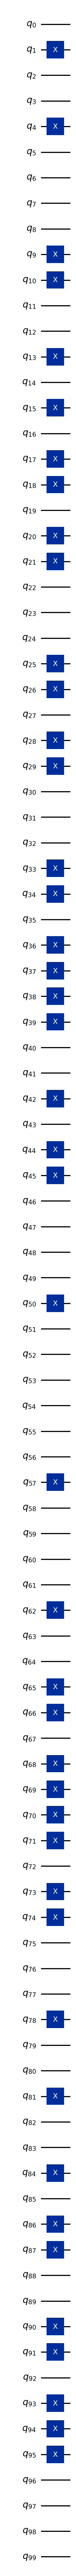

In [4]:
# Prepare a classical message
classical_message = b"Hello, Bob"
print(f"Classical message m: {classical_message}")

# Generate a signature for this message using Dilithium2
signature = Dilithium2.sign(sk, classical_message)
print(f"Signature s: {signature}")

# Convert classical data to binary
def classical_to_binary(data):
    return ''.join(format(byte, '08b') for byte in data)

binary_message = classical_to_binary(classical_message)
binary_signature = classical_to_binary(signature)
binary_data = binary_message + binary_signature

# Encode into quantum states
def encode_to_qubits(binary_data):
    n = len(binary_data)
    qc = QuantumCircuit(n)
    for i, bit in enumerate(binary_data):
        if bit == '1':
            qc.x(i) # Apply X-gate for |1> states
    return qc

quantum_encode = encode_to_qubits(binary_data)

# Assume 'quantum_encode' is the original large circuit
num_required_qubits = 100  # Number of qubits required for the first operations

# Create a new circuit with a new quantum register
new_register = QuantumRegister(num_required_qubits, 'q')
small_circuit = QuantumCircuit(new_register)

# Map original qubits to the new circuit's qubits
qubit_mapping = {old_qubit: new_qubit for old_qubit, new_qubit in zip(quantum_encode.qubits, new_register)}

# Add the first two operations to the new circuit with remapped qubits
for op in quantum_encode.data[:44]:  # First two operations
    remapped_qubits = [qubit_mapping[q] for q in op.qubits]  # Remap the qubits
    small_circuit.append(op.operation, remapped_qubits)

# Draw the smaller circuit
small_circuit.draw(output='mpl')

In [5]:
# I tried to just put the quantum state and the small circuit together but that kept resulting in errors because you can't just add two quantum circuits
# The solution was to first check the number of qubits for both circuits then create a new circuit
# and use the "compose" function which basically concatenates them and then puts them in this new circuit

# Ensure the combined circuit has enough qubits for both circuits
total_qubits = qc_message.num_qubits + quantum_encode.num_qubits
combined_circuit = QuantumCircuit(total_qubits)

# Add qc_quantum to the combined circuit
combined_circuit.compose(qc_message, range(qc_message.num_qubits), inplace=True)

# Add quantum_encode to the combined circuit starting from the next available qubit index
start_index = qc_message.num_qubits
combined_circuit.compose(
    quantum_encode, 
    qubits=range(start_index, start_index + quantum_encode.num_qubits), 
    inplace=True
)

Skipping operation x due to insufficient qubits.
Skipping operation x due to insufficient qubits.
Skipping operation x due to insufficient qubits.
Skipping operation x due to insufficient qubits.
Skipping operation x due to insufficient qubits.
Skipping operation x due to insufficient qubits.
Skipping operation x due to insufficient qubits.
Skipping operation x due to insufficient qubits.
Skipping operation x due to insufficient qubits.
Skipping operation x due to insufficient qubits.
Skipping operation x due to insufficient qubits.
Skipping operation x due to insufficient qubits.
Skipping operation x due to insufficient qubits.
Skipping operation x due to insufficient qubits.
Skipping operation x due to insufficient qubits.
Skipping operation x due to insufficient qubits.


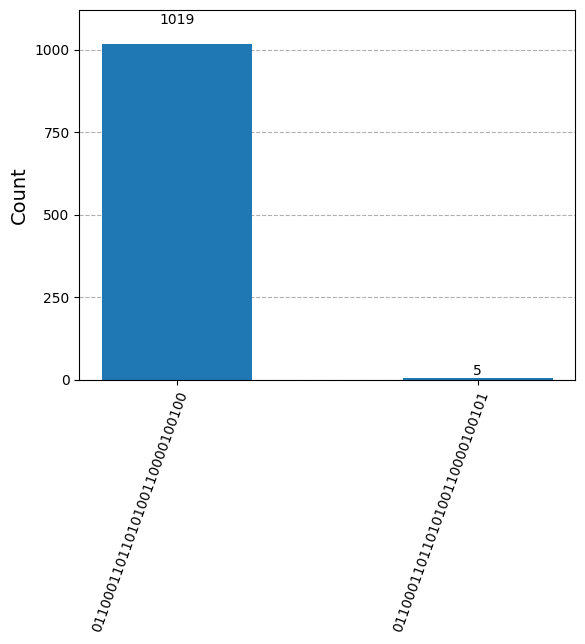

In [6]:
# Now we have to reduce the combined circuit size again because it's too large to be handled
# Create a reduced circuit with fewer qubits
num_reduced_qubits = 29  # Set the maximum number of qubits for testing
reduced_register = QuantumRegister(num_reduced_qubits, "q")
reduced_circuit = QuantumCircuit(reduced_register)

# Map the original qubits to the reduced circuit's qubits
original_to_reduced_mapping = {
    original_qubit: reduced_register[i]
    for i, original_qubit in enumerate(combined_circuit.qubits[:num_reduced_qubits])
}

# Add the first 29 operations with remapped qubits
for op in combined_circuit.data[:29]:
    # Remap qubits based on the mapping
    remapped_qubits = [original_to_reduced_mapping.get(q) for q in op.qubits]

    # Check if the number of remapped qubits matches the gate's requirement
    if None in remapped_qubits or len(remapped_qubits) != op.operation.num_qubits:
        print(f"Skipping operation {op.operation.name} due to insufficient qubits.")
        continue

    # Append the operation to the reduced circuit
    reduced_circuit.append(op.operation, remapped_qubits)

# Add measurement gates
reduced_circuit.measure_all()

# Initialize the Aer simulator
simulator = AerSimulator()

# Transpile and execute the reduced circuit
compiled_circuit = transpile(reduced_circuit, simulator)
job = simulator.run(compiled_circuit, shots=1024)
result = job.result()
counts = result.get_counts()

# Visualize results
plot_histogram(counts)

In [7]:
print("Full Circuit:")
print(reduced_circuit.draw(output='text'))

Full Circuit:
         ┌─────────┐ ░ ┌─┐                                                   »
    q_0: ┤ Ry(314) ├─░─┤M├───────────────────────────────────────────────────»
         └─────────┘ ░ └╥┘┌─┐                                                »
    q_1: ────────────░──╫─┤M├────────────────────────────────────────────────»
            ┌───┐    ░  ║ └╥┘┌─┐                                             »
    q_2: ───┤ X ├────░──╫──╫─┤M├─────────────────────────────────────────────»
            └───┘    ░  ║  ║ └╥┘┌─┐                                          »
    q_3: ────────────░──╫──╫──╫─┤M├──────────────────────────────────────────»
                     ░  ║  ║  ║ └╥┘┌─┐                                       »
    q_4: ────────────░──╫──╫──╫──╫─┤M├───────────────────────────────────────»
            ┌───┐    ░  ║  ║  ║  ║ └╥┘┌─┐                                    »
    q_5: ───┤ X ├────░──╫──╫──╫──╫──╫─┤M├────────────────────────────────────»
            └───┘    ░  ║  ║  ║  ║  ║ 

In [8]:
# This part was added due to memory management errors that kept coming up from the above cell
#Serialize the circuit to a QPY byte stream
byte_stream = BytesIO()
qpy.dump([reduced_circuit], byte_stream)
qpy_serialized_circuit = byte_stream.getvalue()  # Extract byte data
print("Serialized circuit to QPY format.")

Serialized circuit to QPY format.


In [9]:
# Now use Kyber to generate keys
ek, dk = ML_KEM_512.keygen()
shared_secret, ciphertext = ML_KEM_512.encaps(ek)
print(f"Shared secret: {shared_secret.hex()}")

# Encrypt the serialized circuit using the shared secret
print("Encrypting serialized circuit using the shared secret...")
cipher = AES.new(shared_secret, AES.MODE_CBC)  # Create AES cipher with shared_secret as the key
iv = cipher.iv  # Initialization vector for AES
encrypted_circuit = cipher.encrypt(pad(qpy_serialized_circuit, AES.block_size))  # Encrypt with padding
print("Circuit encryption complete.")
print(f"Encrypted Message (Ciphertext): {ciphertext.hex()}")

# Transmit the ciphertext (encrypted circuit and the encapsulated key)
transmitted_ciphertext = (ciphertext, iv, encrypted_circuit)

Shared secret: 5277197f68403c13dc095bd3fcab7888d282af2bc1d41fc1a30ca48090c70fa1
Encrypting serialized circuit using the shared secret...
Circuit encryption complete.
Encrypted Message (Ciphertext): 2cd6a6682bde02c53fcd0be566498a580e86587824bf2db235ada06622a40591ee7439bc2ca60e1c2f9a9753b395484f947b9aff0117c579a7847112d5b307d5ea5de0f74949470a4c6afc01307715052d7010304da380cca6f29f2e0b4c6250cd4721967a59ddae73b5413bfb7d07cff9b7539c192308b7b2eede3f8bc35d9cf34a1816d84e851460138b84f9ba425ab6a58d093e98c39c88264a2c6886c04c8ec6207e4f81a97155047e629fcbf2455ccb1e6987baafd23a3bd64aba93ddc355cc220a6a6742d8799c9c6505e2af4d8974934a5826c806f358d0af205d330c1f4de3b17367c1b8cca946e09d3e3d893a5356f6b61ba374ba47e97168a7b67efb0b0b57ec8a3a221286f25f96a276e3a685035e477fd3fe4c110825f115e30ffeba54192a621c865ee2b67eff736011226d5735edaa7a658e85c5c07cc5b3ffdc2585b76e232887c9e8804c2884c01690387afdb129935a1b442042bcc89b2c4ad611df5b66559acf7e200ad9887661513289f74c31fedf9e8446b767185497064456f713bfe81b9b3a8bbe57456304d5

In [10]:
# Unsigncryption
# Step 1: Decrypt the shared secret using Bob's private key
print("Decrypting shared secret...")
decrypted_shared_secret = ML_KEM_512.decaps(dk, ciphertext)
print("Shared secret decryption successful.")
print(f"Decrypted Shared Secret: {decrypted_shared_secret.hex()}")

Decrypting shared secret...
Shared secret decryption successful.
Decrypted Shared Secret: 5277197f68403c13dc095bd3fcab7888d282af2bc1d41fc1a30ca48090c70fa1


In [11]:
# Step 2: Decrypt the serialized circuit using the shared secret
print("Decrypting serialized circuit...")
cipher = AES.new(decrypted_shared_secret, AES.MODE_CBC, iv)  # Recreate AES cipher with shared_secret
decrypted_circuit_data = unpad(cipher.decrypt(encrypted_circuit), AES.block_size)  # Decrypt and unpad
print("Circuit decryption complete.")
print(f"Decrypted Circuit Data (binary): {decrypted_circuit_data}")

Decrypting serialized circuit...
Circuit decryption complete.
Decrypted Circuit Data (binary): b'QISKIT\x0c\x01\x02\x04\x00\x00\x00\x00\x00\x00\x00\x01eq\x00\x0bf\x00\x08\x00\x00\x00\x1d\x00\x00\x00\x1d\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00+\x00\x00\x00\x00circuit-173\x00\x00\x00\x00\x00\x00\x00\x00{}q\x01\x00\x00\x00\x1d\x00\x01\x01q\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00\x05\x00\x00\x00\x00\x00\x00\x00\x06\x00\x00\x00\x00\x00\x00\x00\x07\x00\x00\x00\x00\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\t\x00\x00\x00\x00\x00\x00\x00\n\x00\x00\x00\x00\x00\x00\x00\x0b\x00\x00\x00\x00\x00\x00\x00\x0c\x00\x00\x00\x00\x00\x00\x00\r\x00\x00\x00\x00\x00\x00\x00\x0e\x00\x00\x00\x00\x00\x00\x00\x0f\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00\x00\x00\x00\x00\x00\x11\x00\x00\x00\x00\x00\x00\x00\x12\x00\x00\x00\x00\x00\x00

In [12]:
# Step 3: Deserialize the QPY circuit
byte_stream = BytesIO(decrypted_circuit_data)
reconstructed_circuits = qpy.load(byte_stream)

In [13]:
# Extract the first circuit (assuming only one circuit was serialized)
reconstructed_circuit = reconstructed_circuits[0]
print("Reconstructed Circuit:")
print(reconstructed_circuit.draw(output='text'))

Reconstructed Circuit:
         ┌─────────┐ ░ ┌─┐                                                   »
    q_0: ┤ Ry(314) ├─░─┤M├───────────────────────────────────────────────────»
         └─────────┘ ░ └╥┘┌─┐                                                »
    q_1: ────────────░──╫─┤M├────────────────────────────────────────────────»
            ┌───┐    ░  ║ └╥┘┌─┐                                             »
    q_2: ───┤ X ├────░──╫──╫─┤M├─────────────────────────────────────────────»
            └───┘    ░  ║  ║ └╥┘┌─┐                                          »
    q_3: ────────────░──╫──╫──╫─┤M├──────────────────────────────────────────»
                     ░  ║  ║  ║ └╥┘┌─┐                                       »
    q_4: ────────────░──╫──╫──╫──╫─┤M├───────────────────────────────────────»
            ┌───┐    ░  ║  ║  ║  ║ └╥┘┌─┐                                    »
    q_5: ───┤ X ├────░──╫──╫──╫──╫──╫─┤M├────────────────────────────────────»
            └───┘    ░  ║  ║ 

In [14]:
# Step 4: Extract classical data from the reconstructed circuit
# Simulate the circuit to get measurement outcomes
compiled_circuit = transpile(reconstructed_circuit, simulator)
job = simulator.run(compiled_circuit, shots=1)  # Single shot to get one measurement result
result = job.result()
measurement = list(result.get_counts().keys())[0]  # Get the measured binary string

In [15]:
# Convert binary strings back to classical data
def binary_to_classical(binary_data):
    return bytes(int(binary_data[i : i + 8], 2) for i in range(0, len(binary_data), 8))

recovered_message = binary_to_classical(binary_message)
recovered_signature = binary_to_classical(binary_signature)
print(f"Recovered Message: {recovered_message}")
print(f"Recovered Signature: {recovered_signature}")

Recovered Message: b'Hello, Bob'
Recovered Signature: b'K7\x7f\xd0A\x96\x97\xc6\xc9L\x13\xe1\x19\x84\xca8\xc0q\x03\n\xbev\xa6l\xc6\xd1_\'K\x98]\x07\xc4\xb7\xbb\x16\x12\xdb&\xaaX\x86\xab\xd7C\xf8\x0fF*R\x9a\xe8\xc8\xb1\xa9Q\x19J\xf9\xf3"h\xe1]\xfa\xf1O\xe9\xc2G\x10\x9a\xf4\x11\x1e\xa9\x82\xd0v;\xe5\xa3]>k\xe2H{v\xdf\r\xd4\x0b\xaa\x7f\xcc\r\xef\x13\x84\xedw\xd8\xb8\xd42;+-\xe5o>\xd2\xa9:\x1c\x86\x00\xa1\x94_)\xcaXV\xc3%B\xd5S* \x0e.\xec\xefE\x8c\x05 \xcd\xb6\xfa\xdf\xa1\x06\xce.\t\xd6\x97\x1e(\xaan\xa6[6\xa5S\x8e\'L\x8f"\x8d\x12S9\xce:@\xb1\xea\xc2\xcb\xc1-+k\x01P\xb4X\x00J\xad\xd2\x80\xeev\xa0!\xab)<\xaep\x82\x83k\x0b70|IS\x1a\xd7\xb5\x9dp\xd1\xa4\xd2\xe0\xb3\xbe1\xff3\xca4W7\x8a\xcc\xf3\xbf\x8e\xd3\xd7n\xc5I\xc0\x9eGY\xe3|\x92*L\x0f\xf3\x97\xfcI\xbbN\xab\x9b~\x9f\xa4\x8b\xce\x99\xd5lN\xf8jo\xc3\xa0N\x15N\x11\x92\x13\xcd80\x86L+\x0f\xc3QQz\x95zh\xfc)6w\x82D\xb9\xb4\xde\x19\x03A/\x04y\t\xd4X?\xd3zA\xc96\xc2\xee|\x06c9/\xe1~\x9d\xcc\x8b3\xda\xa8\x92a\xd8\xe1\x16\x1b\x1a9f\x16\x8ci\xb5\xf5

In [16]:
# Step 5: Verify the signature using Dilithium2
print("Verifying signature...")
is_valid = Dilithium2.verify(pk, recovered_message, recovered_signature)
if is_valid:
    print("Signature verification successful!")
else:
    print("Signature verification failed!")
    raise ValueError("The signature is invalid.")

Verifying signature...
Signature verification successful!


In [17]:
# Add measurement gates to the reconstructed circuit
reconstructed_circuit.measure_all()

# Simulate the circuit to get measurement results
compiled_circuit = transpile(reconstructed_circuit, simulator)
job = simulator.run(compiled_circuit, shots=1024)  # Simulate with 1024 shots
result = job.result()
counts = result.get_counts()

# Print the measurement results
print("Measurement outcomes (counts):")
print(counts)

Measurement outcomes (counts):
{'01100011011010100110000100100 01100011011010100110000100100': 1020, '01100011011010100110000100101 01100011011010100110000100101': 4}
